In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math

<Figure size 432x288 with 0 Axes>

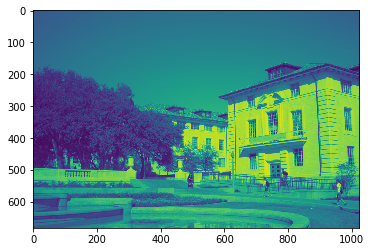

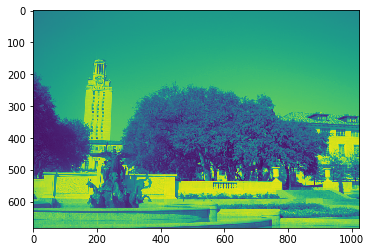

<Figure size 432x288 with 0 Axes>

In [2]:
#reading right image and converting it into grayscale
img_1=cv2.imread("uttower_right.JPG")
img1= cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
plt.imshow(img1)
plt.figure()
#reading left image and converting it into grayscale
img_2=cv2.imread("uttower_left.JPG")
img2= cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)
plt.imshow(img2)
plt.figure()

In [3]:
#find out keypoints and descriptors using sift algorithm
sift = cv2.xfeatures2d.SIFT_create()
# find the key points and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1,None)
keypoints2, descriptors2 = sift.detectAndCompute(img2,None)

<Figure size 432x288 with 0 Axes>

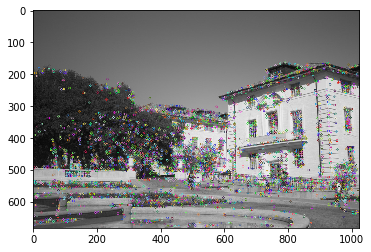

<Figure size 432x288 with 0 Axes>

In [4]:
#plotting key points
img3=cv2.drawKeypoints(img1,keypoints1,None)
plt.imshow(img3)
plt.figure()

In [5]:
# finding correspondances from extracted keypoints of both images
match = cv2.BFMatcher()
matches = match.knnMatch(descriptors1,descriptors2,k=2)


In [6]:
#extracting good keypoints by having some threshold
good = []
for m,n in matches:
    if m.distance < 0.27*n.distance:
        good.append(m)
#corrs = np.matrix(good)

<Figure size 432x288 with 0 Axes>

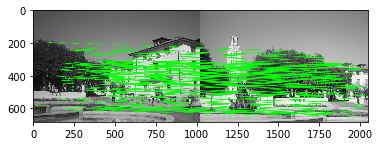

<Figure size 432x288 with 0 Axes>

In [7]:
#drawing the correspondances in both images
draw_parameters = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)
img4 = cv2.drawMatches(img1,keypoints1,img2,keypoints2,good,None,**draw_parameters)
plt.imshow(img4)
plt.figure()

In [8]:
#Homography matrix calculation
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #singular value decomposition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

In [9]:
#calculate the geometric distance between estimated points andoriginal points
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


In [10]:
#functions to plot inlier points with red dots
def plot_points(img_1,img_2,inliers):

    rows1 = img_1.shape[0]
    cols1 = img_1.shape[1]
    rows2 = img_2.shape[0]
    cols2 = img_2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1,:] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:cols1+cols2,:] = np.dstack([img2, img2, img2])
    
    for i in inliers:
            x1 = i.item(0)
            y1 = i.item(1)
            x2 = i.item(2)
            y2 = i.item(3)
            
            cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
            cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)
    plt.imshow(out)
    plt.show()

In [11]:
def averageResidual(inliers):
    sum=0
    for i in inliers:
        x1 = i.item(0)
        y1 = i.item(1)
        x2 = i.item(2)
        y2 = i.item(3)
        sum += math.sqrt(((x1-x2)**2) + ((y1-y2)**2))
    avg = sum/(float)(len(inliers))
    print("The average residuals for inliers is:",avg,end=" ")
    print()

In [12]:
#ransac algorithm which creates homographies from random correspondences 
def ransac(corr, thresh,img_1,img_2):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []
        
        #calling geometric distance function
        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        print("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    #calling plot_points function
    plot_points(img_1,img_2,maxInliers)
    #plot1_points(img_2,maxInliers)
    averageResidual(maxInliers)
    return finalH, maxInliers


Corr size:  170  NumInliers:  168 Max inliers:  168


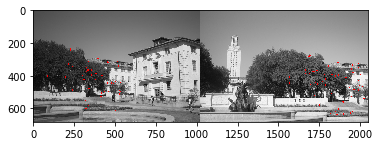

The average residuals for inliers is: 454.9469721981786 


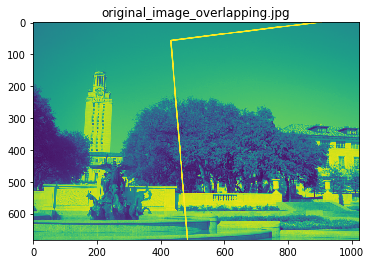

<Figure size 432x288 with 0 Axes>

In [13]:
#Finding Homography marix 
MIN_MATCH_COUNT = 10
correspondenceList=[]
if len(good) > MIN_MATCH_COUNT:
    
    for m in good:
        (x1,y1) = keypoints1[m.queryIdx].pt
        (x2,y2) = keypoints2[m.trainIdx].pt
        correspondenceList.append([x1,y1,x2,y2])
    corrs = np.matrix(correspondenceList)
    M,inliers = ransac(corrs,0.6,img_1,img_2)
    #M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img5 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    plt.imshow(img5)
    plt.title("original_image_overlapping.jpg")
    plt.figure()
else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))

In [14]:
#Here we warp perspective to essentially change the field of view 
dst = cv2.warpPerspective(img_1,M,(img_2.shape[1] + img_1.shape[1], img_2.shape[0]))
dst[0:img_2.shape[0], 0:img_2.shape[1]] = img_2

In [15]:
#Dark side of the image is removed here after stitching
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])    
    return frame

True

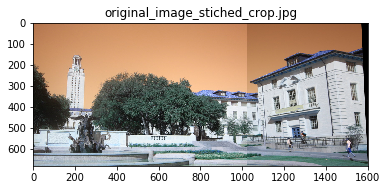

<Figure size 432x288 with 0 Axes>

In [16]:
t=trim(dst)
plt.imshow(t)
plt.title("original_image_stiched_crop.jpg")
plt.figure()
cv2.imwrite("original_image_stiched_crop.jpg",t)